# Simple Reinforcement Learning: Exploration Strategies

이 노트북은 학습 과정 동안 탐색을 장려하기 위해 사용될 수 있는 다양한 행동 선택 방법들의 구현을 포함한다.

In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.contrib.slim as slim

# 환경 불러오기

In [2]:
env = gym.make('CartPole-v0')

[2017-02-15 01:34:05,919] Making new env: CartPole-v0


# The Deep Q-Network

## Helper functions

In [3]:
# 이전에 소개했지만, 에피소드별 걸음을 다 모으는 경험 버퍼
class experience_buffer():
    def __init__(self, buffer_size = 10000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])
    
# target network를 tau 만큼 증가시키는 함수    
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:int(total_vars/2)]):
        op_holder.append(tfVars[idx+int(total_vars/2)].assign((var.value()*tau) + ((1-tau)*tfVars[idx+int(total_vars/2)].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

# 신경망 구현하기

In [4]:
class Q_Network():
    def __init__(self):
        # 행동 선택을 위한 순전파를 구현하는 부분
        self.inputs = tf.placeholder(shape=[None,4],dtype=tf.float32)
        # boltzmann 을 위한 온도 변수
        self.Temp = tf.placeholder(shape=None,dtype=tf.float32)
        # bayesian을 위한 dropout keep 변수
        self.keep_per = tf.placeholder(shape=None,dtype=tf.float32)
        
        # 은닉층은 64개
        hidden = slim.fully_connected(self.inputs,64,activation_fn=tf.nn.relu,biases_initializer=None)
        hidden = slim.dropout(hidden,self.keep_per)
        # 예측된 행동 값들
        self.Q_out = slim.fully_connected(hidden,2,activation_fn=None,biases_initializer=None)
        
        # boltzmann을 위한 softmax
        self.predict = tf.argmax(self.Q_out,1)
        self.Q_dist = tf.nn.softmax(self.Q_out/self.Temp)
        
        
        # target Q 와 Q value의 손실 계산
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,2,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.mul(self.Q_out, self.actions_onehot), reduction_indices=1)
        
        self.nextQ = tf.placeholder(shape=[None],dtype=tf.float32)
        loss = tf.reduce_sum(tf.square(self.nextQ - self.Q))
        trainer = tf.train.GradientDescentOptimizer(learning_rate=0.0005)
        self.updateModel = trainer.minimize(loss)

# 신경망 학습하기

In [5]:
# 학습 파라미터 설정
# greedy, random, e-greedy, boltzmann, bayesian 사이에서 선택
# 탐색 방법
exploration = "bayesian" 
# 할인 인자
y = .99 
# 에피소드 몇번 학습할지
num_episodes = 10000
# target 신경망을 얼마만큼 업데이트할지
tau = 0.001
# 배치 사이즈
batch_size = 32 
# 초기 무작위 확률 값
startE = 1
# 최종 무작위 확률 값
endE = 0.1
# 몇번에 걸쳐서 줄일 것인가
anneling_steps = 200000
# 학습 시작 전에 경험 버퍼에 저장할 걸음을 만들어 내는 무작위 걸음
pre_train_steps = 50000

In [6]:
# 텐서플로 그래프를 초기화
tf.reset_default_graph()

# 주요 신경망
q_net = Q_Network()
# 타겟 신경망
target_net = Q_Network()

# 변수 초기화
init = tf.global_variables_initializer()
# 학습 가능한 변수 추출
trainables = tf.trainable_variables()
# target 신경망 초기화
targetOps = updateTargetGraph(trainables,tau)
# 경험버퍼 초기화
myBuffer = experience_buffer()


# 에피소드별 총 보상과 걸음 저장
jList = []
jMeans = []
rList = []
rMeans = []

# gpu 에러를 방지
config = tf.ConfigProto(
        device_count={'GPU': 0}  # uncomment this line to force CPU
    )

# 텐서플로 시작
with tf.Session(config=config) as sess:
    # 변수 초기화
    sess.run(init)
    # 타겟 신경망을 주요 신경망과 동일하게 설정
    updateTarget(targetOps,sess)
    # 초기 무작위 확률값
    e = startE
    # 줄여나갈 값
    stepDrop = (startE - endE)/anneling_steps
    # 총 걸음 수
    total_steps = 0
    
    # 에피소드 시작
    for i in range(num_episodes):
        # 상태 초기화
        s = env.reset()
        # 보상 초기화
        rAll = 0
        # 종료여부 초기화
        d = False
        # 걸음수 초기화 (여기서는 움직일 횟수)
        j = 0
        # 999 이전까지 반복
        while j < 999:
            j+=1
            if exploration == "greedy":
                # 최대 기대값 행동 선택
                a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:1.0})
                a = a[0]
            if exploration == "random":
                # 무작위 행동 선택
                a = env.action_space.sample()
            if exploration == "e-greedy":
                # e보다 작은 경우 무작위 행동, 아니면 Q-network 를 통한 행동 선택
                if np.random.rand(1) < e or total_steps < pre_train_steps:
                    a = env.action_space.sample()
                else:
                    a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:1.0})
                    a = a[0]
            if exploration == "boltzmann":
                # Q-value에 상대적으로 가중된 확률적 행동 선택
                Q_d,allQ = sess.run([q_net.Q_dist,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.Temp:e,q_net.keep_per:1.0})
                a = np.random.choice(Q_d[0],p=Q_d[0])
                a = np.argmax(Q_d[0] == a)
            if exploration == "bayesian":
                # bayesian q-network의 dropout 근사로부터 추출된 값들을 사용해 행동 선택
                a,allQ = sess.run([q_net.predict,q_net.Q_out],feed_dict={q_net.inputs:[s],q_net.keep_per:(1-e)+0.1})
                a = a[0]
                
            # 새로운 상태와 보상 얻기
            s1,r,d,_ = env.step(a)
            # 경험 버퍼에 저장
            myBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5]))
            
            # 무작위 확률값 줄여나감
            if e > endE and total_steps > pre_train_steps:
                e -= stepDrop
            
            if total_steps > pre_train_steps and total_steps % 5 == 0:
                # Double-DQN 알고리즘 사용
                trainBatch = myBuffer.sample(batch_size)
                Q1 = sess.run(q_net.predict,feed_dict={q_net.inputs:np.vstack(trainBatch[:,3]),q_net.keep_per:1.0})
                Q2 = sess.run(target_net.Q_out,feed_dict={target_net.inputs:np.vstack(trainBatch[:,3]),target_net.keep_per:1.0})
                end_multiplier = -(trainBatch[:,4] - 1)
                doubleQ = Q2[range(batch_size),Q1]
                targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                _ = sess.run(q_net.updateModel,feed_dict={q_net.inputs:np.vstack(trainBatch[:,0]),q_net.nextQ:targetQ,q_net.keep_per:1.0,q_net.actions:trainBatch[:,1]})
                updateTarget(targetOps,sess)
            
            # 총 보상 더 하기
            rAll += r
            # 상태 업데이트
            s = s1
            # 걸음 업데이트
            total_steps += 1
            # 종료
            if d == True:
                break
        jList.append(j)
        rList.append(rAll)
        if i % 100 == 0 and i != 0:
            r_mean = np.mean(rList[-100:])
            j_mean = np.mean(jList[-100:])
            if exploration == 'e-greedy':
                print ("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " e: " + str(e))
            if exploration == 'boltzmann':
                print ("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " t: " + str(e))
            if exploration == 'bayesian':
                print ("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps) + " p: " + str(e))
            if exploration == 'random' or exploration == 'greedy':
                print ("Mean Reward: " + str(r_mean) + " Total Steps: " + str(total_steps))
            rMeans.append(r_mean)
            jMeans.append(j_mean)
print ("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Mean Reward: 14.2 Total Steps: 1434 p: 1
Mean Reward: 14.3 Total Steps: 2864 p: 1
Mean Reward: 14.18 Total Steps: 4282 p: 1
Mean Reward: 14.96 Total Steps: 5778 p: 1
Mean Reward: 13.03 Total Steps: 7081 p: 1
Mean Reward: 13.44 Total Steps: 8425 p: 1
Mean Reward: 13.05 Total Steps: 9730 p: 1
Mean Reward: 13.76 Total Steps: 11106 p: 1
Mean Reward: 14.47 Total Steps: 12553 p: 1
Mean Reward: 13.9 Total Steps: 13943 p: 1
Mean Reward: 13.74 Total Steps: 15317 p: 1
Mean Reward: 14.24 Total Steps: 16741 p: 1
Mean Reward: 14.09 Total Steps: 18150 p: 1
Mean Reward: 13.86 Total Steps: 19536 p: 1
Mean Reward: 14.38 Total Steps: 20974 p: 1
Mean Reward: 13.47 Total Steps: 22321 p: 1
Mean Reward: 14.57 Total Steps: 23778 p: 1
Mean Reward: 14.04 Total Steps: 25182 p: 1
Mean Reward: 13.91 Total Steps: 26573 p: 1
Mean Reward: 13.9 Total Steps: 27963 p: 1
Mean Reward: 13.95 Total Steps: 29358 p: 1
Mean Reward: 13.91 Total Steps: 30749 p: 1
Mean Reward: 13.59 Total Steps: 32108 p: 1
Mean Reward: 14.37 Tot

# 신경망 성능에 대한 몇가지 통계

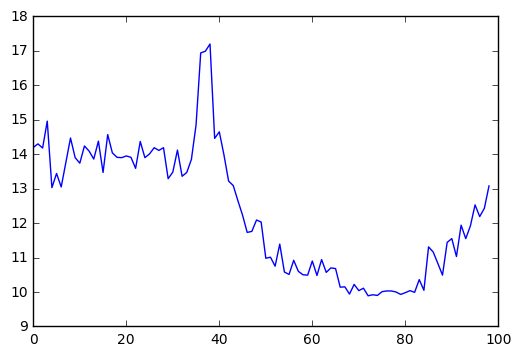

In [7]:
plt.plot(rMeans)

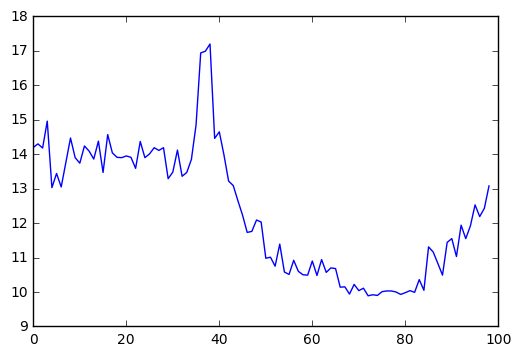

In [8]:
plt.plot(jMeans)